In [1]:
# 1. Load & Overview
import pandas as pd
import numpy as np
import os

data = "train_data.csv"  # adjust if needed

raw = pd.read_csv(os.path.join("..", "data", data))
print(f"Shape: {raw.shape}")
raw.head()

Shape: (1172, 11)


,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Acer,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia GeForce GTX 1050 Ti,Linux,2.5kg,52161.120
1,Asus,Notebook,14.0,1366x768,Intel Celeron Dual Core N3350 1.1GHz,4GB,32GB Flash Storage,Intel HD Graphics 500,Windows 10,1.5kg,14811.840
2,Dell,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics,Linux,2.2kg,14646.672
3,Lenovo,2 in 1 Convertible,14.0,Touchscreen 2560x1440,Intel Core i7 7500U 2.7GHz,16GB,1TB SSD,Intel HD Graphics 620,Windows 10,1.42kg,150462.720
4,Acer,Notebook,15.6,1366x768,Intel Core i3 6006U 2GHz,4GB,500GB HDD,Intel HD Graphics 520,Windows 10,2.4kg,23976.000


In [9]:
# 2. Data Quality Summary
print("--- Missing Values (count) ---")
print(raw.isna().sum())
print("\n--- Duplicated Rows ---")
print(raw.duplicated().sum())
print("\nData Types:")
print(raw.dtypes)

describe_num = raw.select_dtypes(include=[np.number]).describe().T
print("\nNumeric Summary:")
describe_num

--- Missing Values (count) ---
Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64

--- Duplicated Rows ---
25

Data Types:
Company              object
TypeName             object
Inches              float64
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
Price               float64
dtype: object

Numeric Summary:


,count,mean,std,min,25%,50%,75%,max
Inches,1172.0,15.043430,1.412570,10.10,14.00,15.60,15.6000,17.30
Price,1172.0,60081.426123,37460.969532,9270.72,32114.52,52161.12,79346.8404,324954.72


In [10]:
# 3. Feature Parsing / Engineering Preview (mirror logic from preprocessing)
import re

# RAM numeric
def parse_ram(value: str):
    m = re.search(r'(\d+)GB', str(value))
    return float(m.group(1)) if m else np.nan

raw['RAM_GB'] = raw['Ram'].apply(parse_ram)

# Storage decomposition (simple view)
ssd, hdd, flash = [], [], []
for mem in raw['Memory']:
    mem_str = str(mem)
    ssd_val = 0; hdd_val = 0; flash_val = 0
    parts = [p.strip() for p in mem_str.split('+')]
    for p in parts:
        size = None
        tb = re.search(r'([0-9]*\.?[0-9]+)TB', p, re.I)
        gb = re.search(r'([0-9]*\.?[0-9]+)GB', p, re.I)
        if tb:
            size = float(tb.group(1))*1024
        elif gb:
            size = float(gb.group(1))
        if size is None:
            continue
        pl = p.lower()
        if 'ssd' in pl:
            ssd_val += size
        elif 'hdd' in pl:
            hdd_val += size
        elif 'flash' in pl:
            flash_val += size
        else:
            ssd_val += size
    ssd.append(ssd_val); hdd.append(hdd_val); flash.append(flash_val)
raw['mem_ssd_gb'] = ssd
raw['mem_hdd_gb'] = hdd
raw['mem_flash_gb'] = flash

raw[['RAM_GB','mem_ssd_gb','mem_hdd_gb','mem_flash_gb']].head()

,RAM_GB,mem_ssd_gb,mem_hdd_gb,mem_flash_gb
0,8.0,256.0,0.0,0.0
1,4.0,0.0,0.0,32.0
2,4.0,0.0,500.0,0.0
3,16.0,1024.0,0.0,0.0
4,4.0,0.0,500.0,0.0


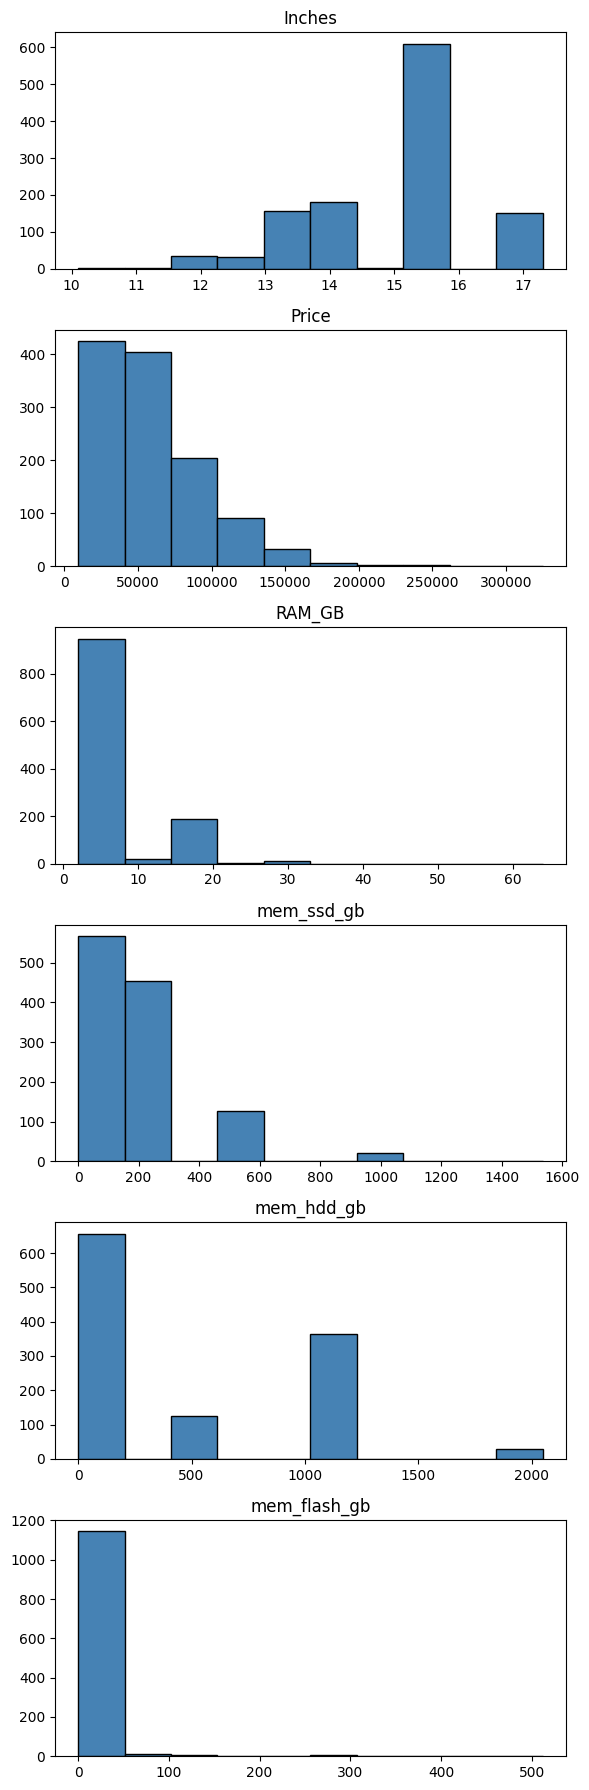

['Inches', 'Price', 'RAM_GB', 'mem_ssd_gb', 'mem_hdd_gb', 'mem_flash_gb']

In [14]:
# 4. Univariate Distributions (numeric)
import matplotlib.pyplot as plt
num_cols = raw.select_dtypes(include=[np.number]).columns.tolist()
fig, axes = plt.subplots(len(num_cols), 1, figsize=(6, 3*len(num_cols)))
if len(num_cols) == 1:
    axes = [axes]
for ax, col in zip(axes, num_cols):
    ax.hist(raw[col].dropna(), bins=10, color='steelblue', edgecolor='black')
    ax.set_title(col)
plt.tight_layout()
plt.show()
num_cols

In [15]:
# 5. Categorical Levels & Cardinality
cat_cols = [c for c in raw.columns if c not in raw.select_dtypes(include=[np.number]).columns and c != 'Price']
summary = []
for c in cat_cols:
    uniq = raw[c].nunique()
    top_vals = raw[c].value_counts().head(5).to_dict()
    summary.append((c, uniq, top_vals))
summary

[('Company',
  19,
  {'Lenovo': 268, 'Dell': 262, 'HP': 253, 'Asus': 138, 'Acer': 95}),
 ('TypeName',
  6,
  {'Notebook': 660,
   'Gaming': 187,
   'Ultrabook': 172,
   '2 in 1 Convertible': 103,
   'Workstation': 27}),
 ('ScreenResolution',
  39,
  {'Full HD 1920x1080': 460,
   '1366x768': 251,
   'IPS Panel Full HD 1920x1080': 216,
   'IPS Panel Full HD / Touchscreen 1920x1080': 46,
   'Full HD / Touchscreen 1920x1080': 38}),
 ('Cpu',
  111,
  {'Intel Core i5 7200U 2.5GHz': 167,
   'Intel Core i7 7700HQ 2.8GHz': 138,
   'Intel Core i7 7500U 2.7GHz': 118,
   'Intel Core i7 8550U 1.8GHz': 69,
   'Intel Core i5 8250U 1.6GHz': 69}),
 ('Ram', 9, {'8GB': 556, '4GB': 338, '16GB': 187, '6GB': 35, '12GB': 20}),
 ('Memory',
  38,
  {'256GB SSD': 369,
   '1TB HDD': 197,
   '500GB HDD': 122,
   '512GB SSD': 109,
   '128GB SSD +  1TB HDD': 84}),
 ('Gpu',
  104,
  {'Intel HD Graphics 620': 248,
   'Intel HD Graphics 520': 160,
   'Intel UHD Graphics 620': 64,
   'Nvidia GeForce GTX 1050': 60,
   '

In [16]:
# 6. Relationship with Target (numeric correlations & simple group means)
# Numeric correlations
corrs = raw[num_cols].corr()['Price'].sort_values(ascending=False)
print("Correlation with Price:\n", corrs)

# Group means for top categorical columns (limited sample size caution)
cat_means = {}
for c in cat_cols:
    if c == 'Price':
        continue
    # Only compute if not too many categories for readability
    if raw[c].nunique() <= 10:
        cat_means[c] = raw.groupby(c)['Price'].mean().sort_values(ascending=False).to_dict()
cat_means

Correlation with Price:
 Price           1.000000
RAM_GB          0.742514
mem_ssd_gb      0.613494
Inches          0.072210
mem_flash_gb   -0.030833
mem_hdd_gb     -0.093074
Name: Price, dtype: float64


{'TypeName': {'Workstation': 122775.68906666666,
  'Gaming': 92515.20395294117,
  'Ultrabook': 82003.69096744186,
  '2 in 1 Convertible': 69074.40596504854,
  'Notebook': 42177.05264727273,
  'Netbook': 32347.446260869565},
 'Ram': {'64GB': 211788.0,
  '32GB': 189045.88283076923,
  '24GB': 117553.44,
  '16GB': 103567.55301818182,
  '12GB': 66301.52544,
  '8GB': 62862.608279136686,
  '6GB': 32850.088457142854,
  '4GB': 30614.53982485207,
  '2GB': 13218.207157894736},
 'OpSys': {'macOS': 93220.32738461539,
  'Windows 7': 90998.71337142857,
  'Windows 10 S': 76219.704,
  'Mac OS X': 68045.94308571429,
  'Windows 10': 62401.91577939646,
  'Linux': 32508.423883636362,
  'No OS': 31867.545363934423,
  'Chrome OS': 26057.915999999997,
  'Android': 23123.52}}

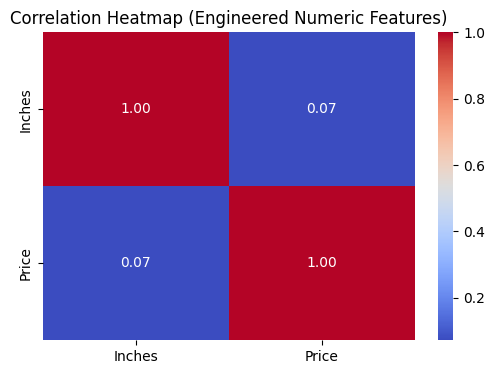

In [ ]:
# 7. Correlation Heatmap 
import seaborn as sns
import matplotlib.pyplot as plt

# dropping string columns for heatmap clarity
# tried wasn't working
num_for_heatmap = raw.select_dtypes(include=[np.number]).columns.tolist()
raw = raw[num_for_heatmap]

plt.figure(figsize=(6,4))
sns.heatmap(raw.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Engineered Numeric Features)')
plt.show()